In [1]:
import mujoco
import dm_control.mujoco
from mujoco import viewer
import random
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET




In [2]:
#### Evolutionary Algorithm
def evolution(xml, gen, bodies_per_gen, iterations_body):


    i=0 #generation iteration counter
    j=0 #body iteration counter
    
    best_body_fitness = 0
    best_body = 0
    
    best_gen_fitness = []
    gen_list = []
    xml_list = []
    best_specimen = []
    
    while i<gen:
        while j<bodies_per_gen:
            fitness = mutate(xml,i,j, iterations_body)                    #Mutate the model, simulate and determine the fitness of the model       
            xml_list.append("new.xml")
            if fitness > best_body_fitness:
                best_body_fitness = fitness
                best_body = j
            j+=1
            
        if j==bodies_per_gen:
            print(best_body_fitness, best_body)
            best_gen_fitness.append(best_body_fitness)
            
            if best_body_fitness > np.argmax(best_gen_fitness):              #Compare to fitness value of prev generations to see what the best evolution seed is
                xml = xml_list[best_body]
                best_specimen.append(best_body)
            j=0
            
        
        gen_list.append(i+1)
        #print(best_gen_fitness)
        xml_list = []  #reset values
        best_body_fitness = 0   
        best_body = 0
        
        i+=1
    
    print(best_gen_fitness)
    print(best_specimen)
    plot(gen_list, best_gen_fitness)


In [3]:
### MUTATE ###
def mutate(best_xml_file,i,j, iterations_body):
    tree = ET.parse(best_xml_file)
    root = tree.getroot()
    if (random.uniform(0,1)>0.25):  #mutate if random generation is >0.25 to throw further variability into each generation
        
        ###Modify main body size and mass and arm size and mass
        body_geom = root.find(".//body[@name='geodude_body']/body/geom")
        body_geom.set('mass', str(float(body_geom.get('mass'))*random.uniform(0.85,1.15))) #body mass change
        #body_geom.set('size', str(float(body_geom.get('size'))*random.uniform(0.85,1.15))) #body size change
        
        arm_geom = root.find(".//body[@name='arm1']/body/geom")
        arm_geom.set('mass', str(float(arm_geom.get('mass'))*random.uniform(0.85,1.15)))  #arm mass change
        arm_geom.set('size', str(float(arm_geom.get('size'))*random.uniform(0.85,1.15)))  #arm size change
        
        arm_geom = root.find(".//body[@name='arm2']/body/geom")
        arm_geom.set('mass', str(float(arm_geom.get('mass'))*random.uniform(0.85,1.15)))  #arm mass change
        arm_geom.set('size', str(float(arm_geom.get('size'))*random.uniform(0.85,1.15)))  #arm size change
           
    tree.write(f"Gen{i}Body{j}.xml")   #write to new xml files
    tree.write("new.xml") 

    model = mujoco.MjModel.from_xml_path("new.xml") #read to mujoco model viewer
    data = mujoco.MjData(model)  
     
    joint_range = 45 #arm motion range
    
    iterations = 0 #iteration counter
    i=0

    with mujoco.viewer.launch_passive(model, data) as viewer:
        viewer.cam.azimuth = 45
        viewer.cam.elevation = -20
        viewer.cam.distance = 10

        while iterations < iterations_body:
            iterations += 1 

            while i < len(data.ctrl):  #
                ctrl = np.deg2rad(joint_range * random.uniform(-1,1))  #Randomize angle of actuation within a joint range
                data.ctrl[i] = ctrl
                i+=1
            i=0

            dm_control.mujoco.mj_step(model, data)
            #viewer.sync()                              ### Comment these two lines out to speed up code heavily
            #time.sleep(1/1000)
                
            
    final_pos = data.qpos[:3]
    #print(final_pos)
    fitness = np.sqrt((final_pos[0])**2+(final_pos[1])**2+(final_pos[2])**2) #fitness is just the total distance traveled by the geodude from the origin, ignoring the drop distance
    #print(fitness)  
    return fitness


In [4]:
def plot(gen_list, best_gen_fitness):   #plot best fitness of each generation, which is the seed for the next generation
    plt.figure()
    plt.plot(gen_list, best_gen_fitness)  
    plt.xlabel('Generation')
    plt.ylabel('Highest Fitness')
    plt.title('Best Evolved fitness Values')
    plt.show()
    plt.savefig("fitness.png")

0.3815130352236127 13
0.3838099696657163 11
0.35440204686150395 0
0.3190231354681688 18
0.37789173172703844 15
0.36377901517668493 12
0.4216119769114899 11
0.45336622960994033 17
0.3327561604845516 8
0.30077114567940466 11
[0.3815130352236127, 0.3838099696657163, 0.35440204686150395, 0.3190231354681688, 0.37789173172703844, 0.36377901517668493, 0.4216119769114899, 0.45336622960994033, 0.3327561604845516, 0.30077114567940466]
[13]


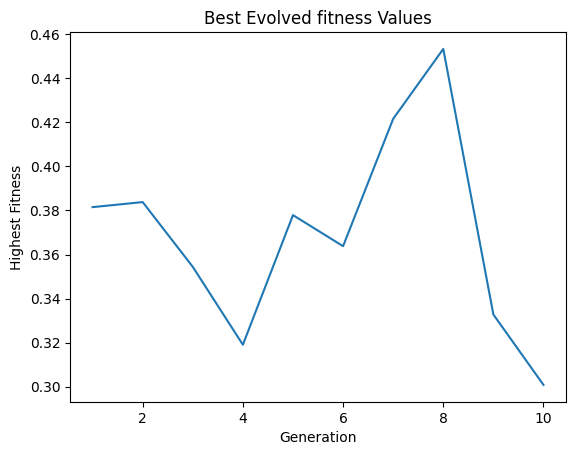

<Figure size 640x480 with 0 Axes>

In [5]:
evolution("geodude.xml", 10, 20, 5000)

In [6]:
#if __name__ == "__main__":
    #evolution("geodude.xml", 10, 100, 5000)